In [1]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dimod
from minorminer import find_embedding
from random_lp.lp_random_gen import RandomLP

# Show embedding of a given problem into pegasus graph

# Problem statement:
Given $A\in Z^{mxn}, b\in Z^{m}, c\in Z^{n}$ 

find $x\in F_2^n$ with:

$\min c^T x $ with constraint $Ax\le b$ 


In [2]:
var = 3
cstr = 3

multiple = 1
penalty = 1

lp_bin = RandomLP.create_random_binary_prog("test_" + str(0), cstr, var, multiple=multiple, penalty=penalty)
qp = lp_bin.qubo

lp_bin.complexity()

10

## Construct graph G for quadratic program as qubo

In [3]:
bqm = dimod.AdjVectorBQM(qp.objective.linear.to_array(),
                         qp.objective.quadratic.to_dict(),
                         qp.objective.constant,
                         vartype=dimod.BINARY)

G = bqm.to_networkx_graph()

In [4]:
labels = {}
variables, constraints = [], []
for key, value in qp.variables_index.items():
    if 'slack' in key:
        label = ''
        constraints.append(value)
    else:
        label = key[1:]
        variables.append(value)
    labels[value] = label
    
var_edges, cstr_edges = G.subgraph(variables).edges, G.subgraph(constraints).edges

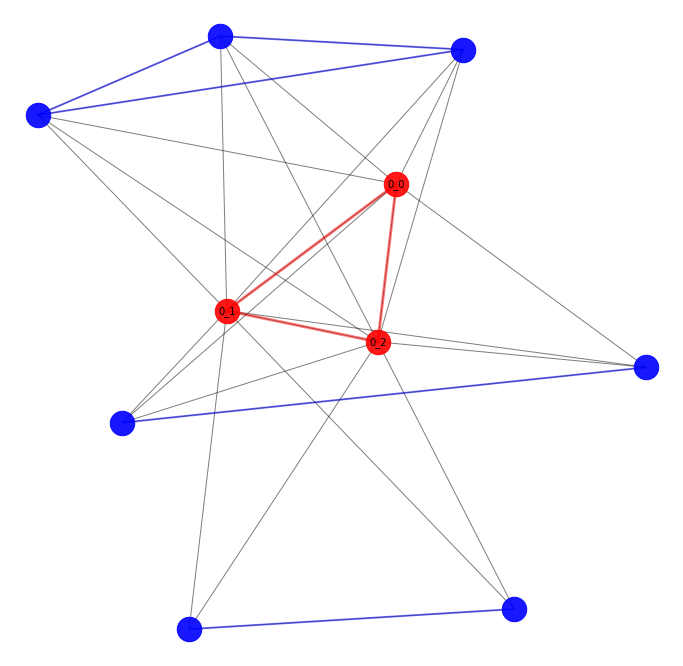

In [5]:
options = {"node_size": 600, "alpha": 0.9}
plt.figure(1, figsize=(12,12)) 

#pos = nx.circular_layout(G)
pos = nx.spring_layout(G, k=0.2, iterations=15, seed=1)
# k controls the distance between the nodes and varies between 0 and 1
    # iterations is the number of times simulated annealing is run
    # default k =0.1 and iterations=50
    
# draw each component individually ? 

nx.draw_networkx_nodes(G, pos, nodelist=variables, node_color="r", **options)
nx.draw_networkx_nodes(G, pos, nodelist=constraints, node_color="b", **options)

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=var_edges,
    width=3,
    alpha=0.5,
    edge_color="r",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=cstr_edges,
    width=2,
    alpha=0.5,
    edge_color="b",
)

nx.draw_networkx_labels(G, pos, labels, font_size=10)

plt.axis("off")
plt.show()

## Find embedding for qubo problem

In [6]:
P_16 = dnx.pegasus_graph(16)
embedding = find_embedding(G, P_16, timeout=60, tries=50)
P_16_sub = P_16.subgraph(list(itertools.chain(*embedding.values())))

In [7]:
P_16_labels = {}
P_16_constraints = []
P_16_variables = []
P_16_chains = []
for key, value in embedding.items():
    for node in value:
        if key in constraints:
            P_16_constraints.append(node)
        else:
            P_16_variables.append(node)
        P_16_labels[node] = labels[key]
    if len(value) > 1:
        P_16_chains.append(value)

P_16_var_edges, P_16_cstr_edges = P_16_sub.subgraph(P_16_variables).edges, P_16_sub.subgraph(P_16_constraints).edges

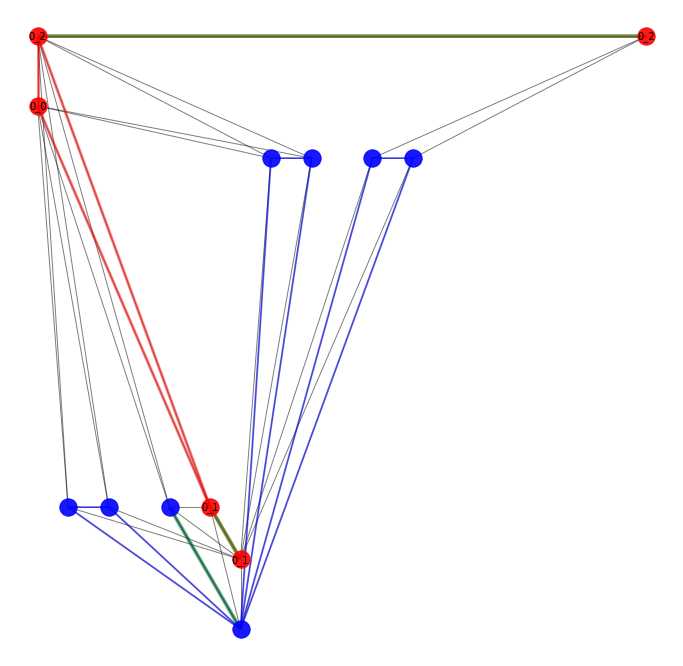

In [8]:
options = {"node_size": 300, "alpha": 0.9}
plt.figure(2, figsize=(12,12)) 

pos = dnx.pegasus_layout(P_16_sub)


nx.draw_networkx_nodes(P_16_sub, pos, nodelist=P_16_variables, node_color="r", **options)
nx.draw_networkx_nodes(P_16_sub, pos, nodelist=P_16_constraints, node_color="b", **options)

nx.draw_networkx_edges(P_16_sub, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    P_16_sub,
    pos,
    edgelist=P_16_var_edges,
    width=3,
    alpha=0.5,
    edge_color="r",
)
nx.draw_networkx_edges(
    P_16_sub,
    pos,
    edgelist=P_16_cstr_edges,
    width=2,
    alpha=0.5,
    edge_color="b",
)

nx.draw_networkx_edges(
    P_16_sub,
    pos,
    edgelist=P_16_chains,
    width=4,
    alpha=0.5,
    edge_color="g",
)
nx.draw_networkx_labels(P_16_sub, pos, P_16_labels, font_size=10)

plt.axis("off")
plt.show()

In [9]:
structured_sampler = dimod.StructureComposite(DWaveSampler(), P_16.nodes, P_16.edges)
sampler = FixedEmbeddingComposite(structured_sampler, embedding=embedding)

In [10]:
res = sampler.sample(bqm, label="embedding_of_random_lp", num_reads=100)

In [11]:
res.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,chain_break_fraction,energy,num_occurrences
0,1,0,1,0,0,1,0,0,0,0,0.0,-3.0,5
1,1,0,1,0,0,0,1,0,0,0,0.0,-2.0,4
2,1,0,1,0,0,1,0,0,0,1,0.0,-2.0,2
3,1,0,1,0,0,0,0,0,0,0,0.0,-2.0,4
4,1,0,1,1,0,1,0,0,0,0,0.0,-2.0,2
5,1,0,1,0,0,1,0,0,1,0,0.0,-2.0,2
6,1,0,1,0,0,0,1,0,0,1,0.0,-1.0,3
7,1,0,0,1,0,0,1,0,1,1,0.0,-1.0,9
8,1,0,1,0,0,0,0,0,1,0,0.0,-1.0,1
9,1,0,0,1,0,1,1,0,1,1,0.0,0.0,3


In [13]:
solution = res.first.sample

solution

{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0}

In [18]:
qp.get_feasibility_info(solution.values())

(True, [], [])

In [20]:
from qiskit.optimization.algorithms import CplexOptimizer
cplex = CplexOptimizer()
cplex.solve(qp)

optimal function value: -3.0
optimal value: [1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
status: SUCCESS